In [ ]:
!pip install obspy tqdm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from obspy import read
print("ObsPy version:", read)

ObsPy version: <function read at 0x7a449b54af20>


In [ ]:
from obspy.signal.filter import bandpass

plt.rcParams["figure.figsize"] = (12, 4)

In [ ]:
!wget -q https://examples.obspy.org/RJOB_061005_072159.ehz.new -O earthquake.mseed


In [ ]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt


In [ ]:
client = Client("IRIS")


In [ ]:
t1 = UTCDateTime("2010-02-27T06:34:00")
t2 = t1 + 300  # 5 minutes window

eq_stream = client.get_waveforms(
    network="IU",
    station="ANMO",
    location="00",
    channel="BHZ",
    starttime=t1,
    endtime=t2
)

print(eq_stream)


1 Trace(s) in Stream:
IU.ANMO.00.BHZ | 2010-02-27T06:34:00.019538Z - 2010-02-27T06:38:59.969538Z | 20.0 Hz, 6000 samples


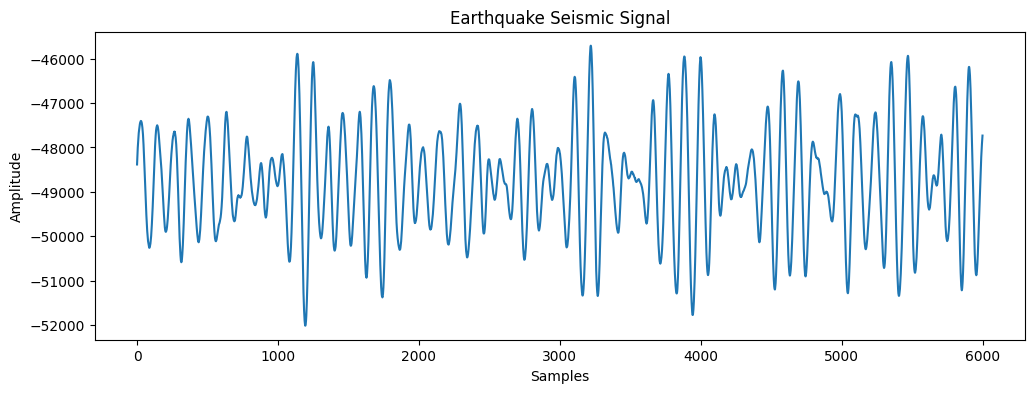

In [ ]:
eq_trace = eq_stream[0]

plt.figure(figsize=(12,4))
plt.plot(eq_trace.data)
plt.title("Earthquake Seismic Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


In [ ]:
t1_noise = UTCDateTime("2010-02-20T00:00:00")
t2_noise = t1_noise + 300

noise_stream = client.get_waveforms(
    network="IU",
    station="ANMO",
    location="00",
    channel="BHZ",
    starttime=t1_noise,
    endtime=t2_noise
)

print(noise_stream)


1 Trace(s) in Stream:
IU.ANMO.00.BHZ | 2010-02-20T00:00:00.019500Z - 2010-02-20T00:04:59.969500Z | 20.0 Hz, 6000 samples


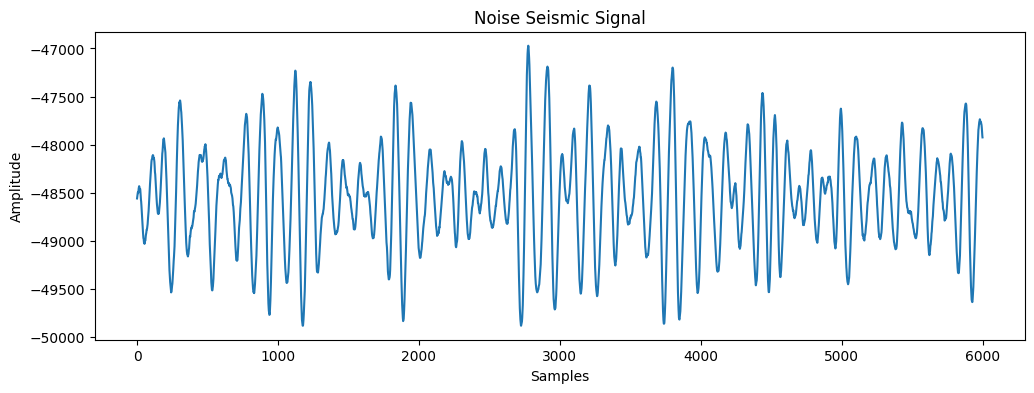

In [ ]:
noise_trace = noise_stream[0]

plt.figure(figsize=(12,4))
plt.plot(noise_trace.data)
plt.title("Noise Seismic Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


In [ ]:


eq_trace_detrended = eq_trace.copy()
noise_trace_detrended = noise_trace.copy()

eq_trace_detrended.detrend(type="linear")
noise_trace_detrended.detrend(type="linear")


IU.ANMO.00.BHZ | 2010-02-20T00:00:00.019500Z - 2010-02-20T00:04:59.969500Z | 20.0 Hz, 6000 samples

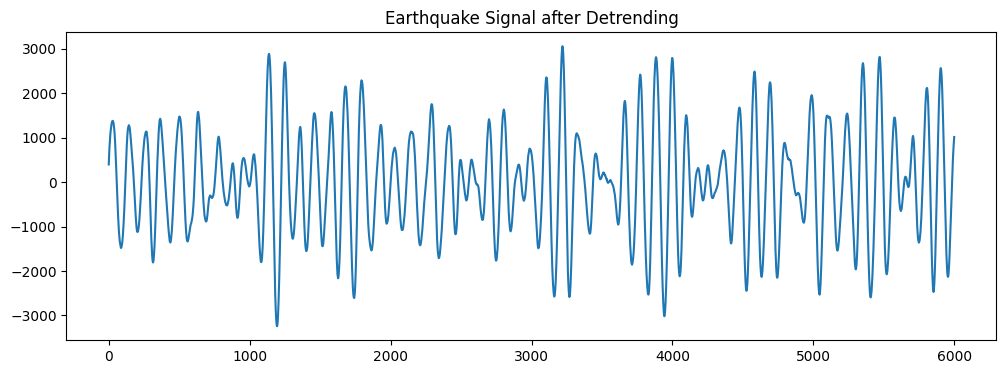

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(eq_trace_detrended.data)
plt.title("Earthquake Signal after Detrending")
plt.show()


In [ ]:
from obspy.signal.filter import bandpass

fs = eq_trace.stats.sampling_rate  # sampling rate (Hz)

eq_filtered = bandpass(
    eq_trace_detrended.data,
    freqmin=1.0,
    freqmax=20.0,
    df=fs,
    corners=4,
    zerophase=True
)

noise_filtered = bandpass(
    noise_trace_detrended.data,
    freqmin=1.0,
    freqmax=20.0,
    df=fs,
    corners=4,
    zerophase=True
)


/usr/local/lib/python3.12/dist-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (20.0) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)


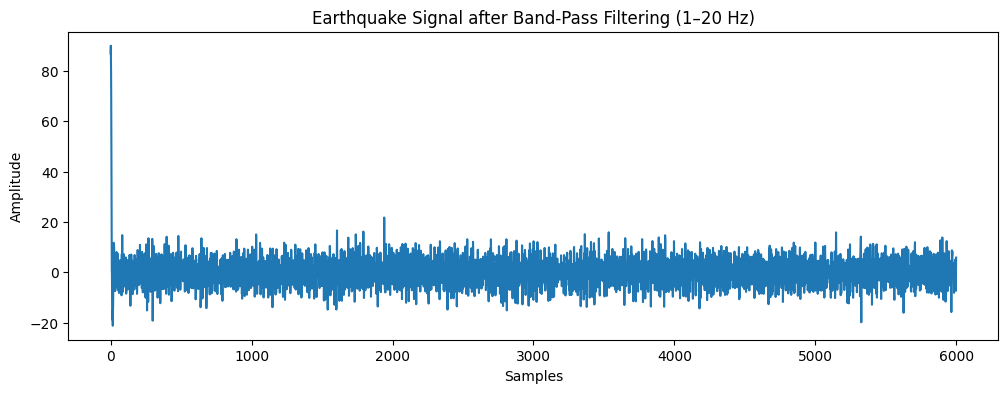

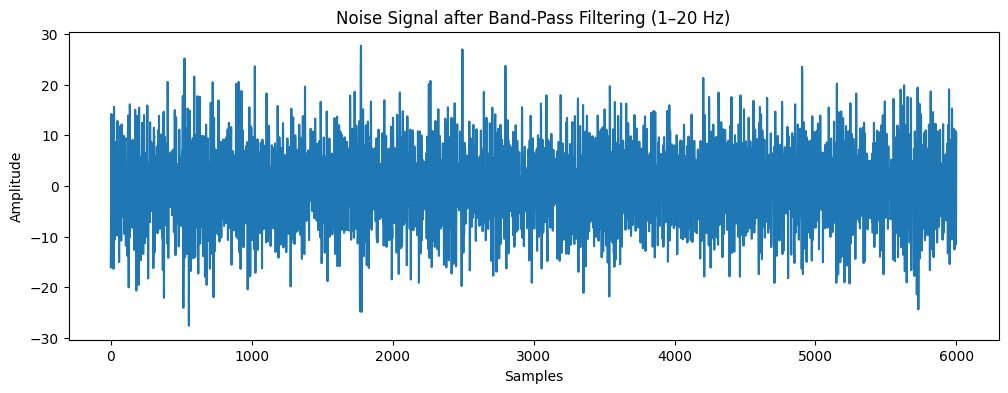

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(eq_filtered)
plt.title("Earthquake Signal after Band-Pass Filtering (1–20 Hz)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(noise_filtered)
plt.title("Noise Signal after Band-Pass Filtering (1–20 Hz)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


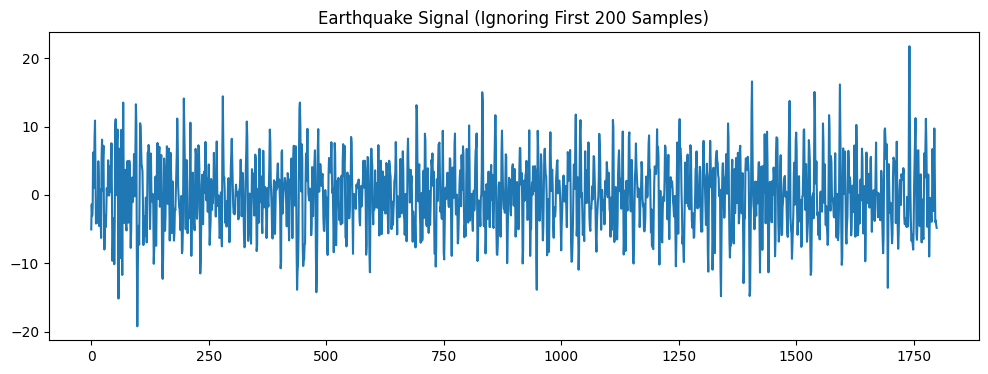

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(eq_filtered[200:2000])
plt.title("Earthquake Signal (Ignoring First 200 Samples)")
plt.show()


In [ ]:
import numpy as np

def create_windows(signal, window_size, step_size):
    """
    signal: 1D numpy array
    window_size: number of samples per window
    step_size: shift between windows (controls overlap)
    """
    windows = []
    for start in range(0, len(signal) - window_size, step_size):
        window = signal[start:start + window_size]
        windows.append(window)
    return np.array(windows)


In [ ]:
fs = eq_trace.stats.sampling_rate  # Hz
window_size = int(5 * fs)          # 5 seconds → 500 samples
step_size = window_size // 2       # 50% overlap


In [ ]:
eq_windows = create_windows(eq_filtered, window_size, step_size)
noise_windows = create_windows(noise_filtered, window_size, step_size)

print("Earthquake windows shape:", eq_windows.shape)
print("Noise windows shape:", noise_windows.shape)


Earthquake windows shape: (118, 100)
Noise windows shape: (118, 100)


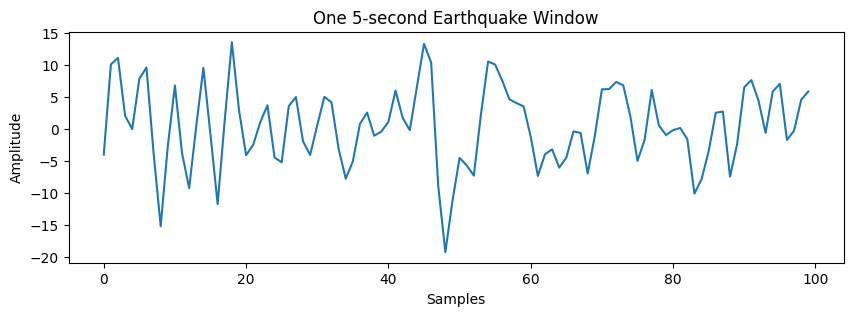

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(eq_windows[5])
plt.title("One 5-second Earthquake Window")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


In [ ]:
def normalize_windows(windows):
    mean = windows.mean(axis=1, keepdims=True)
    std = windows.std(axis=1, keepdims=True)
    return (windows - mean) / (std + 1e-8)


In [ ]:
eq_windows_norm = normalize_windows(eq_windows)
noise_windows_norm = normalize_windows(noise_windows)

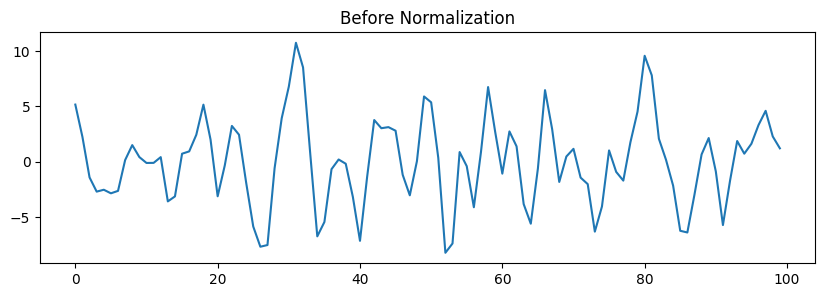

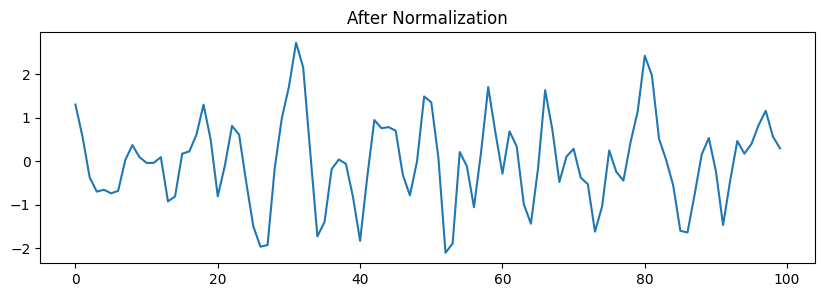

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(eq_windows[10])
plt.title("Before Normalization")
plt.show()

plt.figure(figsize=(10,3))
plt.plot(eq_windows_norm[10])
plt.title("After Normalization")
plt.show()

In [ ]:
X = np.vstack([eq_windows_norm, noise_windows_norm])
y = np.hstack([
    np.ones(len(eq_windows_norm)),
    np.zeros(len(noise_windows_norm))
])

print("Final dataset shape:", X.shape)
print("Labels shape:", y.shape)

Final dataset shape: (236, 100)
Labels shape: (236,)


In [ ]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

In [ ]:
from scipy.stats import skew, kurtosis, entropy

def extract_features(windows, fs):
    features = []

    for w in windows:
        # Time-domain
        mean = np.mean(w)
        std = np.std(w)
        rms = np.sqrt(np.mean(w**2))
        max_amp = np.max(np.abs(w))
        zcr = np.mean(np.diff(np.sign(w)) != 0)
        skewness = skew(w)
        kurt = kurtosis(w)

        # Frequency-domain
        fft_vals = np.abs(np.fft.rfft(w))
        freqs = np.fft.rfftfreq(len(w), d=1/fs)
        fft_norm = fft_vals / np.sum(fft_vals)

        spec_entropy = entropy(fft_norm)
        spec_centroid = np.sum(freqs * fft_vals) / np.sum(fft_vals)
        spectral_energy = np.sum(fft_vals**2)

        features.append([
            mean, std, rms, max_amp,
            zcr, skewness, kurt,
            spec_entropy, spec_centroid,
            spectral_energy
        ])

    return np.array(features)

In [ ]:
fs = eq_trace.stats.sampling_rate

X_features = extract_features(X, fs)
print("Feature matrix shape:", X_features.shape)

Feature matrix shape: (236, 10)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Baseline models
1. Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

2. Random Forest (Strong classical model)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Logistic Regression Results")
print(classification_report(y_test, y_pred_lr))

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))

Logistic Regression Results
              precision    recall  f1-score   support

         0.0       0.87      0.83      0.85        24
         1.0       0.84      0.88      0.86        24

    accuracy                           0.85        48
   macro avg       0.85      0.85      0.85        48
weighted avg       0.85      0.85      0.85        48

Random Forest Results
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89        24
         1.0       0.88      0.92      0.90        24

    accuracy                           0.90        48
   macro avg       0.90      0.90      0.90        48
weighted avg       0.90      0.90      0.90        48



In [ ]:
print(confusion_matrix(y_test, y_pred_rf))

[[21  3]
 [ 2 22]]


check robustness

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)

cv_scores = cross_val_score(
    rf,
    X_features,   # unscaled is fine for RF
    y,
    cv=cv,
    scoring="f1"
)

print("F1 scores across folds:", cv_scores)
print("Mean F1:", cv_scores.mean())
print("Std F1:", cv_scores.std())

F1 scores across folds: [0.90196078 0.84444444 0.90909091 0.95652174 0.8627451 ]
Mean F1: 0.8949525950037458
Std F1: 0.03905934532161558


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[21  3]
 [ 2 22]]
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89        24
         1.0       0.88      0.92      0.90        24

    accuracy                           0.90        48
   macro avg       0.90      0.90      0.90        48
weighted avg       0.90      0.90      0.90        48



Phase 4: DEEP LEARNING ON RAW SEISMIC WAVEFORMS

We gonna use CNN model

In [ ]:
import numpy as np

X_cnn = X[..., np.newaxis]  # shape → (N, 500, 1)
print("CNN input shape:", X_cnn.shape)

CNN input shape: (236, 100, 1)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_cnn, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [ ]:
print(X_train.shape)

(188, 100, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential([
    Conv1D(32, kernel_size=7, activation="relu", input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=5, activation="relu"),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 94, 32)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 47, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 43, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1344)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        86,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,705 (377.75 KB)

 Trainable params: 96,705 (377.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
input_shape=(X_train.shape[1], 1)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.4732 - loss: 0.7045 - val_accuracy: 0.5625 - val_loss: 0.6858
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6057 - loss: 0.6662 - val_accuracy: 0.6458 - val_loss: 0.6806
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6933 - loss: 0.6325 - val_accuracy: 0.6458 - val_loss: 0.6675
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6866 - loss: 0.6189 - val_accuracy: 0.6875 - val_loss: 0.6558
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7897 - loss: 0.5506 - val_accuracy: 0.6875 - val_loss: 0.6447
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8044 - loss: 0.4983 - val_accuracy: 0.6875 - val_loss: 0.6187
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8573 - loss: 0.4331 - val_accuracy: 0.6667 - val_loss: 0.6001
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7866 - loss: 0.4652 - val_accuracy: 0.6458 - val_loss: 0.6214


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

feature_names = [
    "mean", "std", "rms", "max_amp",
    "zcr", "skewness", "kurtosis",
    "spectral_entropy", "spectral_centroid",
    "spectral_energy"
]

rf.fit(X_features, y)

importances = rf.feature_importances_
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feat_imp

,feature,importance
8,spectral_centroid,0.489028
7,spectral_entropy,0.241437
4,zcr,0.125294
9,spectral_energy,0.045317
3,max_amp,0.032437
6,kurtosis,0.026255
5,skewness,0.024546
0,mean,0.015685
1,std,0.000000
2,rms,0.000000


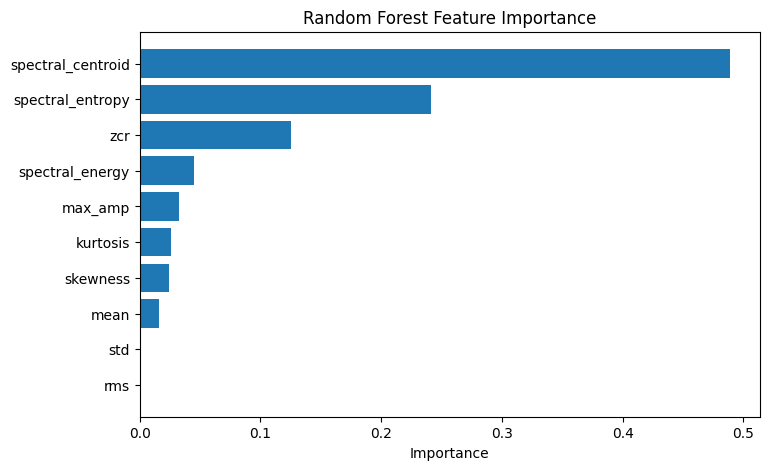

In [ ]:
plt.figure(figsize=(8,5))
plt.barh(feat_imp["feature"], feat_imp["importance"])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.show()

In [ ]:
import tensorflow as tf

sample = tf.convert_to_tensor(X_val[0:1], dtype=tf.float32)

In [ ]:
with tf.GradientTape() as tape:
    tape.watch(sample)
    prediction = model(sample)

grads = tape.gradient(prediction, sample)
saliency = tf.abs(grads)[0, :, 0].numpy()

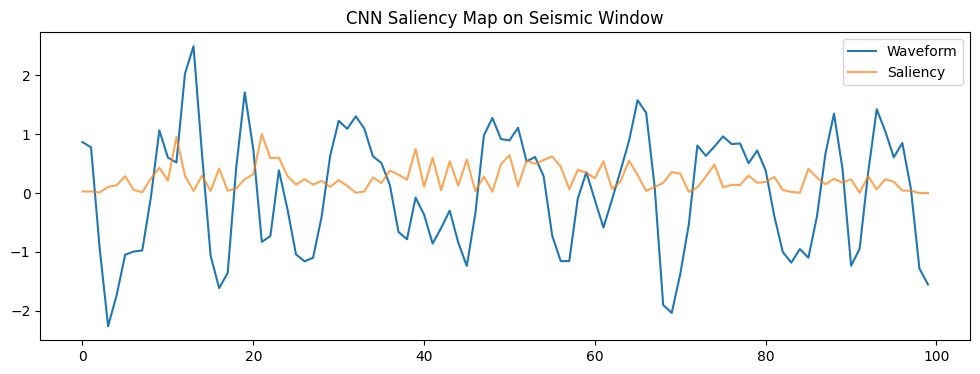

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(sample.numpy()[0, :, 0], label="Waveform")
plt.plot(saliency / saliency.max(), label="Saliency", alpha=0.7)
plt.legend()
plt.title("CNN Saliency Map on Seismic Window")
plt.show()